# Text Classification
> ## Sentiment Analysis of IMDB Movie Reviews
 Pattern Recognition Course Project #1 @<a href="http://www.iust.ac.ir/">IUST</a>

<br>
Hosein Mohebbi<br>
98722531<br>
hosein_mohebbi@comp.iust.ac.ir


# Project Overview

>Text classification is used in many interesting applications such as spam or non-spam email detection, fake news detection, and sentiment analysis. The main aim of this project is to examine different base classifiers in sentiment analysis task as a text classification problem. Sentiment analysis aims to estimate the sentiment polarity of a body of a text solely on its content. To tackle this problem has been tried any possible combination of four approaches to word embedding (BOW, BERT, TF-IDF, Word2Vec) and four base classifiers (Naive Bayes, SVM, Decision Tree, Random Forest) as well as some text pre-processing techniques on the IMDB movie reviews dataset which contains 50K reviews, half of which are positive and the other half negative. This dataset was compiled by <a href="http://ai.stanford.edu/~amaas/">Andrew Maas</a> and can be find here: <a href="http://ai.stanford.edu/~amaas/data/sentiment/">Large Movie Review Dataset</a>



# Downloading & Installing Prerequisites

In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2019-11-12 15:18:03--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  23.7MB/s    in 3.6s    

2019-11-12 15:18:07 (22.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
!tar -zxvf aclImdb_v1.tar.gz > /dev/null

In [0]:
!pip3 install bert-embedding

In [0]:
!pip3 install mxnet-cu100

In [0]:
!pip3 install sentence-transformers

In [0]:
!wget "http://vectors.nlpl.eu/repository/11/40.zip"
!unzip 40.zip
!mv model.bin English_CoNLL17_Corpus.bin

In [3]:
!ls

40.zip	 aclImdb_v1.tar.gz	     LIST	model.txt  sample_data
aclImdb  English_CoNLL17_Corpus.bin  meta.json	README


# Required Packages

In [4]:
import ipywidgets as widgets
import os
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.tag import pos_tag
import re
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import mxnet as mx
from bert_embedding import BertEmbedding
from sentence_transformers import SentenceTransformer
#import gensim.downloader as api
#from gensim import models
import gensim 
from gensim.models import Word2Vec 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Loading DataSet


> Dataset has been divided evenly into a training set and a test set. Moreover, each set contains 12.5K positive and 12.5K negative reviews. The training and test data were loaded in Pandas data frames.



In [0]:
def loadDataset(data_dir):
    
    data = {}
    for partition in ["train", "test"]:
        data[partition] = []
        for sentiment in ["neg", "pos"]:
            lable = 1 if sentiment == "pos" else -1

            path = os.path.join(data_dir, partition, sentiment)
            files = os.listdir(path)
            for f_name in files:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[partition].append([review, lable])

    random.seed(4) # to comparision purpose
    random.shuffle(data["train"])
    random.shuffle(data["test"])
    
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])

    return data["train"], data["test"]

In [0]:
data_dir = "aclImdb/"
train_data, test_data = loadDataset(data_dir)

Here are the first 5 rows of the training data:

In [0]:
# Debugging
train_data.head()

,text,sentiment
0,BE WARNED. This movie is such a mess. It's a c...,-1
1,"""Revolt of the Zombies"" proves that having the...",-1
2,This film is one of the more risqué black and ...,1
3,"I'm a rather pedestrian person, with somewhat ...",1
4,Spoilers.....<br /><br />I saw the original on...,1


# Cleaning Dataset
> Since this dataset scraped from the web, some HTML codes got mixed up with it. So, cleaning up these texts by removing HTML tags is required. Removing numbers, punctuations, and stop words, replacing negative contraction verb with whose complete forms like won't, splitting compound nouns that are made with hyphen like state-of-the-art, and normalizing texts by lowering them would be beneficial.

> To remove stop words, the NLTK stop words set have been used. But, some words which have a negative meaning, such as not or nor, have been removed from the set and some contraction patterns like 're or 'm have been added to stop words set.

> Due to training of the BERT embedding on Wikipedia data, for this model we allow some of the punctuations which may cause a more reliable embedding like [,/():;] to remain in the text. Moreover, we save !,?, and . to detect the end of the sentence for a later purpose (using BERT for each sentence).

> Stemming and lemmatization according to POS tags of words are used for all embedding except BERT.

> Finally, we have replaced white spaces with only one space.


In [0]:
def NormalizeWithPOS(text):
    # Lemmatization & Stemming according to POS tagging

    word_list = word_tokenize(text)
    rev = []
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer() 
    for word, tag in pos_tag(word_list):
        if tag.startswith('J'):
            w = lemmatizer.lemmatize(word, pos='a')
        elif tag.startswith('V'):
            w = lemmatizer.lemmatize(word, pos='v')
        elif tag.startswith('N'):
            w = lemmatizer.lemmatize(word, pos='n')
        elif tag.startswith('R'):
            w = lemmatizer.lemmatize(word, pos='r')
        else:
            w = word
        w = stemmer.stem(w)
        rev.append(w)
    review = ' '.join(rev)
    return review

In [0]:
def cleanText(text):
    
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r"[0-9]+", ' ', text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    if embedding is not 'BERT':
        text = re.sub(r"-", ' ', text)
    
    text = text.strip().lower()
    
    if embedding is 'WORD2VEC_NO_STOP':
        # Remove Stop words
        default_stop_words = set(stopwords.words('english'))
        default_stop_words.difference_update({'no', 'not', 'nor', 'too', 'any'})
        stop_words = default_stop_words.union({"'m", "n't", "'d", "'re", "'s",
                                               'would','must',"'ve","'ll",'may'})
    
        word_list = word_tokenize(text)
        filtered_list = [w for w in word_list if not w in stop_words]
        text = ' '.join(filtered_list)
    
    # Remove other contractions
    text = re.sub(r"'", ' ', text)
    
    # Replace punctuations with space
    if embedding is 'BERT': # save ! ? . for end of sentences [,/():;]
        filters='"\'#$%&*+<=>@[\\]^_`{|}~\t\n'
    else:
        filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    if embedding is not 'BERT':
        text = ' '.join([w for w in text.split() if len(w)>1])

    # Replace multiple space with one space
    text = re.sub(' +', ' ', text)
    
    text = ''.join(text)

    return text

### Adding cleaning reviews as a column in our data frame.

In [0]:
embedding = ''
# for Word2Vec with stop words
train_data['clean_text'] = train_data['text'].apply(cleanText)
test_data['clean_text'] = test_data['text'].apply(cleanText)

In [0]:
# for BOW and TFIDF(s)
train_data['clean_text_normalized'] = train_data['clean_text'].apply(NormalizeWithPOS)
test_data['clean_text_normalized'] = test_data['clean_text'].apply(NormalizeWithPOS)

### Low Frequency Words of Train Data - just for BOW & TFIDF

In [0]:
freq_train = pd.Series(' '.join(train_data['clean_text_normalized']).split()).value_counts()
less_five_freq_train = freq_train[(freq_train <5)]
print(less_five_freq_train)

fluentli          4
rappin            4
osric             4
byu               4
leisin            4
                 ..
wamsi             1
piccioni          1
cowrit            1
supersentiment    1
snowwhit          1
Length: 30478, dtype: int64


### Low Frequency Words of Test Data - just for BOW & TFIDF

In [0]:
freq_test = pd.Series(' '.join(test_data['clean_text_normalized']).split()).value_counts()
less_five_freq_test = freq_test[(freq_test <5)]
print(less_five_freq_test)

splatteri    4
nerva        4
jonestown    4
dehydr       4
mauvi        4
            ..
rybek        1
hootkloot    1
blingin      1
argyl        1
parekh       1
Length: 29958, dtype: int64


### Remove words with frequency less than 5  - just for BOW & TFIDF

In [0]:
train_data['clean_text_normalized'] = train_data['clean_text_normalized'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_train))
test_data['clean_text_normalized'] = test_data['clean_text_normalized'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_test))

### Continue to add cleaning reviews as a column in our data frame:

In [0]:
embedding = 'WORD2VEC_NO_STOP'
# for Word2Vec without stop words
train_data['clean_text_w2v_no_stop'] = train_data['text'].apply(cleanText)
test_data['clean_text_w2v_no_stop'] = test_data['text'].apply(cleanText)

In [0]:
embedding = 'BERT'
# for BERT(s)
train_data['clean_text_bert'] = train_data['text'].apply(cleanText)
test_data['clean_text_bert'] = test_data['text'].apply(cleanText)

In [0]:
# Debugging
print("A review example of dataset before cleaning:", end="\n\n")
print(train_data.iloc[4]['text'], end='\n\n')

print("clean_text:")
print(train_data.iloc[4]['clean_text'], end="\n\n")

print("clean_text_normalized:")
print(train_data.iloc[4]['clean_text_normalized'], end="\n\n")

print("clean_text_w2v_no_stop:")
print(train_data.iloc[4]['clean_text_w2v_no_stop'], end="\n\n")

print("clean_text_bert:")
print(train_data.iloc[4]['clean_text_bert'], end="\n\n")

A review example of dataset before cleaning:

Spoilers.....<br /><br />I saw the original on TV sometime ago and remembered this production as less gripping than most Beeb costume drama. I rewatched on DVD this week and still have the same impression of it. It's a good story at first, but weakens when the heroine becomes oh so terribly brave and noble and returns to her utterly vile husband when he's ill and I got so totally irritated with her saintliness. I suppose this was the "right thing to do" when the story was written as well as contributing plenty of angst, and it was difficult for a woman to be independent of her husband as marriage made her no more than his possession, let alone to carry on scandalously with a lover as I expect a lot of the modern audience would have liked to see. But it's hard to take the santimoniousness nowadays and especially when this heroine had a strong, brave admirer ready to defend her against anyone and everyone. So re the story as in the film I'm e

# Vectorization

> To introduce our data to our classifiers except for Decision Tree, we need to convert each review to numeric features: this is vectorization.

<b>Bag Of Words (BOW):</b>
>  In this approach, we make a list of all the unique words in training data called the vocabulary. then, given an input text, it outputs a numerical vector that counts each word of the vocabulary.

> To use BOW vectorization in Python, we can use the CountVectorizer function from the scikit-learn library. We pass our custom clean text function to remove useless words of training data thereby reducing the size of the BOW vectors until 19366.

<b>TFIDF:</b>
> 

<b>Word2Vec</b>
> 


<b>Bidirectional Encoder Representations  from Transformers (<a href="https://arxiv.org/abs/1810.04805">BERT</a>):</b>
> BERT, published by Google, is pre-trained language model word representation as a vector with the size of 768.</br>

> In this project, we used BERT embedding twice and report them independently. once, we tokenized each training data into words, then calculate BERT embedding of each word, and finally, mean all the BERT vectors of the words as a review representation. In a second way, we tokenized each training data into sentences and computed the mean of BERT embedding of the sentences for each training data.

> To utilize BERT embedding  for two mentioned purposes, we have used these two libraries respectively: </br>
<a href= "https://pypi.org/project/bert-embedding/">bert-embedding 1.0.1</a> </br>
<a href= "https://github.com/UKPLab/sentence-transformers">Sentence Transformers</a>

In [0]:
def mean(z): # used for BERT (word version) and Word2Vec
    return sum(itertools.chain(z))/len(z)

#BOW

In [0]:
embedding = 'BOW'
vectorizer = CountVectorizer(stop_words='english')

bow_training_features = vectorizer.fit_transform(train_data["clean_text_normalized"])    
bow_test_features = vectorizer.transform(test_data["clean_text_normalized"])

print(bow_training_features.shape)

(25000, 19366)


# TF-IDF

> With Stop Words



In [0]:
embedding = 'TFIDF_WITH_STOP'
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)

tfidf_with_stop_training_features = vectorizer.fit_transform(train_data["clean_text_normalized"])    
tfidf_with_stop_test_features = vectorizer.transform(test_data["clean_text_normalized"])

print(tfidf_with_stop_training_features.shape)

(25000, 20000)


# TF-IDF

> Without Stop Words



In [0]:
embedding = 'TFIDF_NO_STOP'
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20000)

tfidf_no_stop_training_features = vectorizer.fit_transform(train_data["clean_text_normalized"])    
tfidf_no_stop_test_features = vectorizer.transform(test_data["clean_text_normalized"])

print(tfidf_no_stop_training_features.shape)

(25000, 20000)


# WORD2VEC

In [0]:
#w2v_model = api.load("word2vec-google-news-300")
#w2v_model = models.KeyedVectors.load_word2vec_format('English_CoNLL17_Corpus.bin', binary=True)

In [0]:
def embeddToWord2Vec(text):
    words = word_tokenize(text)
    
    if embedding is 'WORD2VEC_WITH_STOP':
        result = [w2v_with_stop_model.wv[w] for w in words if w in w2v_with_stop_model.wv.vocab]
    else:
        result = [w2v_no_stop_model.wv[w] for w in words if w in w2v_no_stop_model.wv.vocab]
    
    feature = [mean(x) for x in zip(*result)]
    return feature

In [0]:
def wordTokenize(text):
  return word_tokenize(text)

### Word2Vec

> With Stop Words



In [0]:
embedding = 'WORD2VEC_WITH_STOP'

In [0]:
words = train_data['clean_text'].apply(wordTokenize)
w2v_with_stop_model = gensim.models.Word2Vec(words, min_count = 2, size = 100, window = 5) 

In [0]:
# from gensim.models import FastText
# w2v_model2 = FastText(words, min_count = 0, size = 100, window = 5) 

In [0]:
# w2v_model3 = FastText(size=100, window=5, min_count=1)
# w2v_model3.build_vocab(sentences=words)
# w2v_model3.train(sentences=words, total_examples=len(words), epochs=100)

In [0]:
word2vec_with_stop_training_features = train_data['clean_text'].apply(embeddToWord2Vec)
word2vec_with_stop_test_features = test_data['clean_text'].apply(embeddToWord2Vec)

In [0]:
feature = [x for x in word2vec_with_stop_training_features.transpose()]
word2vec_with_stop_training_features = np.asarray(feature)

feature = [x for x in word2vec_with_stop_test_features.transpose()]
word2vec_with_stop_test_features = np.asarray(feature)

print(word2vec_with_stop_training_features.shape)

(25000, 100)


### Word2Vec

> Without Stop Words



In [0]:
embedding = 'WORD2VEC_NO_STOP'

In [0]:
words = train_data['clean_text_w2v_no_stop'].apply(wordTokenize)
w2v_no_stop_model = gensim.models.Word2Vec(words, min_count = 2, size = 100, window = 5) 

In [0]:
word2vec_no_stop_training_features = train_data['clean_text_w2v_no_stop'].apply(embeddToWord2Vec)
word2vec_no_stop_test_features = test_data['clean_text_w2v_no_stop'].apply(embeddToWord2Vec)

In [0]:
feature = [x for x in word2vec_no_stop_training_features.transpose()]
word2vec_no_stop_training_features = np.asarray(feature)

feature = [x for x in word2vec_no_stop_test_features.transpose()]
word2vec_no_stop_test_features = np.asarray(feature)

print(word2vec_no_stop_training_features.shape)

(25000, 100)


# BERT

In [0]:
# Cleaning before BERT
embedding = 'BERT'

### (BERT)
> Word Tokenization Version



In [0]:
def embeddToBERT(text):
    sentences = re.split('!|\?|\.',text)
    sentences = list(filter(None, sentences)) 

    if bert_version == 'WORD':
        result = bert(sentences, 'avg') # avg is refer to handle OOV
    
        bert_vocabs_of_sentence = []
        for sentence in range(len(result)):
            for word in range(len(result[sentence][1])):
                bert_vocabs_of_sentence.append(result[sentence][1][word])
        feature = [mean(x) for x in zip(*bert_vocabs_of_sentence)]

    elif bert_version == 'SENTENCE':
        result = bert_transformers.encode(sentences)
        feature = [mean(x) for x in zip(*result)]
  
    return feature

In [12]:
ctx = mx.gpu(0)
bert = BertEmbedding(ctx=ctx)

Vocab file is not found. Downloading.


In [0]:
bert_version = 'WORD'
bert_word_training_features = train_data['clean_text_bert'].apply(embeddToBERT)
bert_word_test_features = test_data['clean_text_bert'].apply(embeddToBERT)

In [14]:
feature = [x for x in bert_word_training_features.transpose()]
bert_word_training_features = np.asarray(feature)

feature = [x for x in bert_word_test_features.transpose()]
bert_word_test_features = np.asarray(feature)

print(bert_word_training_features.shape)

(25000, 768)


### (BERT) 
> Sentence Tokenization Version



In [15]:
bert_transformers = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:17<00:00, 23.3MB/s]


In [0]:
bert_version = 'SENTENCE'
bert_sentence_training_features = train_data['clean_text_bert'].apply(embeddToBERT)
bert_sentence_test_features = test_data['clean_text_bert'].apply(embeddToBERT)

In [17]:
feature = [x for x in bert_sentence_training_features.transpose()]
bert_sentence_training_features = np.asarray(feature)

feature = [x for x in bert_sentence_test_features.transpose()]
bert_sentence_test_features = np.asarray(feature)

print(bert_sentence_training_features.shape)

(25000, 768)


# Classifiers

# Model & Training & Evaluation & Result

In [0]:
# A function to plot and print result
def printResult(y_pred, y_prob):
    acc = accuracy_score(test_data["sentiment"], y_pred)
    # Result
    print("Accuracy: {:.2f}".format(acc*100),end='\n\n')
    cm = confusion_matrix(test_data["sentiment"],y_pred)
    print('Confusion Matrix:\n', cm)
    print(classification_report(test_data["sentiment"],y_pred))

    # Plot
    fpr, tpr, thresholds = roc_curve(test_data["sentiment"], y_prob)
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc='lower right')

# SVM

In [0]:
model = SVC(kernel ='linear', C = 1)

> BOW Features

In [0]:
# Training 
model.fit(bow_training_features, train_data["sentiment"])

# Evaluation
y_pred_bow_svm = model.predict(bow_test_features)
y_prob_bow_svm = model.decision_function(bow_test_features)

Accuracy: 81.94

Confusion Matrix:
 [[10429  2071]
 [ 2445 10055]]
              precision    recall  f1-score   support

          -1       0.81      0.83      0.82     12500
           1       0.83      0.80      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Area under the ROC curve : 0.889761


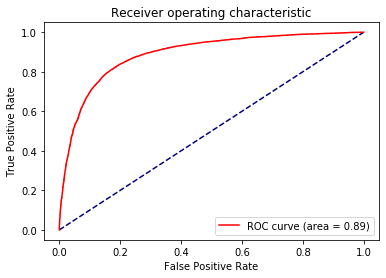

In [0]:
# Result
printResult(y_pred_bow_svm, y_prob_bow_svm)

> TFIDF with Stop Words Features

In [0]:
# Training 
model.fit(tfidf_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_with_stop_svm = model.predict(tfidf_with_stop_test_features)
y_prob_tfidf_with_stop_svm = model.decision_function(tfidf_with_stop_test_features)

Accuracy: 89.58

Confusion Matrix:
 [[11187  1313]
 [ 1292 11208]]
              precision    recall  f1-score   support

          -1       0.90      0.89      0.90     12500
           1       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

Area under the ROC curve : 0.961680


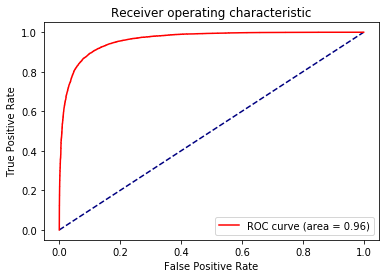

In [0]:
# Result
printResult(y_pred_tfidf_with_stop_svm, y_prob_tfidf_with_stop_svm)

> TFIDF without Stop Words Features

In [0]:
# Training 
model.fit(tfidf_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_no_stop_svm = model.predict(tfidf_no_stop_test_features)
y_prob_tfidf_no_stop_svm = model.decision_function(tfidf_no_stop_test_features)

Accuracy: 87.96

Confusion Matrix:
 [[11043  1457]
 [ 1553 10947]]
              precision    recall  f1-score   support

          -1       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Area under the ROC curve : 0.949729


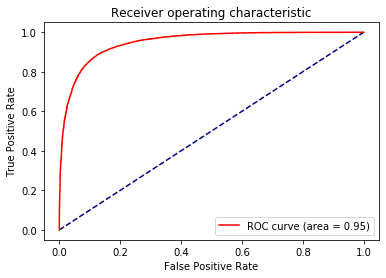

In [0]:
# Result
printResult(y_pred_tfidf_no_stop_svm, y_prob_tfidf_no_stop_svm)

> Word2Vec with Stop Words Features

In [0]:
# Training 
model.fit(word2vec_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_with_stop_svm = model.predict(word2vec_with_stop_test_features)
y_prob_w2v_with_stop_svm = model.decision_function(word2vec_with_stop_test_features)

Accuracy: 83.80

Confusion Matrix:
 [[10506  1994]
 [ 2055 10445]]
              precision    recall  f1-score   support

          -1       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Area under the ROC curve : 0.914843


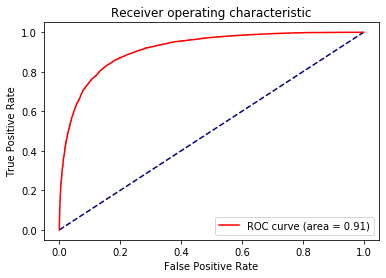

In [0]:
# Result
printResult(y_pred_w2v_with_stop_svm, y_prob_w2v_with_stop_svm)

> Word2Vec without Stop Words Features

In [0]:
# Training 
model.fit(word2vec_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_no_stop_svm = model.predict(word2vec_no_stop_test_features)
y_prob_w2v_no_stop_svm = model.decision_function(word2vec_no_stop_test_features)

Accuracy: 84.49

Confusion Matrix:
 [[10573  1927]
 [ 1951 10549]]
              precision    recall  f1-score   support

          -1       0.84      0.85      0.85     12500
           1       0.85      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Area under the ROC curve : 0.921007


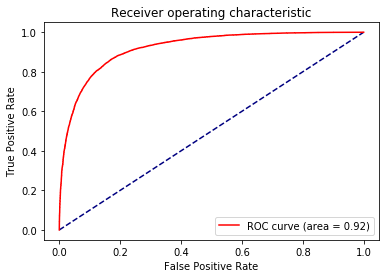

In [0]:
# Result
printResult(y_pred_w2v_no_stop_svm, y_prob_w2v_no_stop_svm)

> BERT Word Version Features

In [0]:
# Training 
model.fit(bert_word_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_words_svm = model.predict(bert_word_test_features)
y_prob_bert_words_svm = model.decision_function(bert_word_test_features)

Accuracy: 87.52

Confusion Matrix:
 [[10950  1550]
 [ 1570 10930]]
              precision    recall  f1-score   support

          -1       0.87      0.88      0.88     12500
           1       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Area under the ROC curve : 0.944975


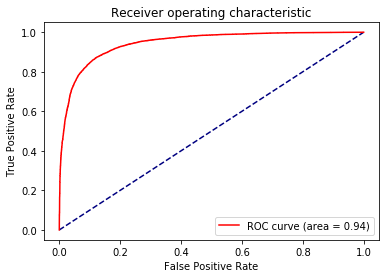

In [21]:
# Result
printResult(y_pred_bert_words_svm, y_prob_bert_words_svm)

> BERT Sentence Version Features

In [0]:
# Training 
model.fit(bert_sentence_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_sentences_svm = model.predict(bert_sentence_test_features)
y_prob_bert_sentences_svm = model.decision_function(bert_sentence_test_features)

Accuracy: 90.07

Confusion Matrix:
 [[11294  1206]
 [ 1277 11223]]
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90     12500
           1       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

Area under the ROC curve : 0.962803


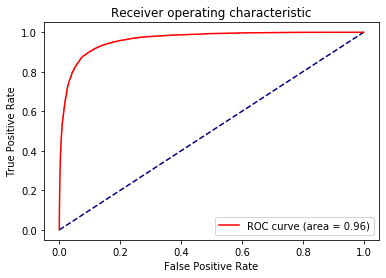

In [23]:
# Result
printResult(y_pred_bert_sentences_svm, y_prob_bert_sentences_svm)

# Naive Bayes

In [0]:
model = MultinomialNB()

> BOW Features

In [0]:
model = MultinomialNB()
# Training
model.fit(bow_training_features.toarray(), train_data["sentiment"])

# Evaluation
y_pred_bow_nb = model.predict(bow_test_features.toarray())

prob_model = model.predict_proba(bow_test_features.toarray())
y_prob_bow_nb = []
for i in range(len(y_pred_bow)):
    y_prob_bow_nb.append(prob_model[i][y_pred_bow_nb[i]])

Accuracy: 81.27

Confusion Matrix:
 [[10887  1613]
 [ 3069  9431]]
              precision    recall  f1-score   support

          -1       0.78      0.87      0.82     12500
           1       0.85      0.75      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       0.82      0.81      0.81     25000

Area under the ROC curve : 0.889681


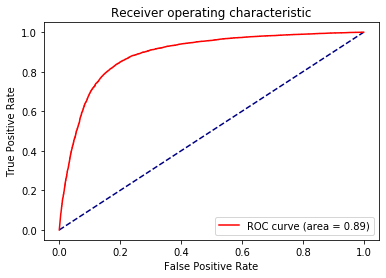

In [0]:
# Result
printResult(y_pred_bow_nb, y_prob_bow_nb)

> TFIDF with Stop Words Features

In [0]:
model = MultinomialNB()
# Training
model.fit(tfidf_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_with_stop_nb = model.predict(tfidf_with_stop_test_features)

prob_model = model.predict_proba(tfidf_with_stop_test_features)
y_prob_tfidf_with_stop_nb = []
for i in range(len(y_pred_tfidf_with_stop_nb)):
    y_prob_tfidf_with_stop_nb.append(prob_model[i][y_pred_tfidf_with_stop_nb[i]])

Accuracy: 86.31

Confusion Matrix:
 [[10887  1613]
 [ 1810 10690]]
              precision    recall  f1-score   support

          -1       0.86      0.87      0.86     12500
           1       0.87      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Area under the ROC curve : 0.938173


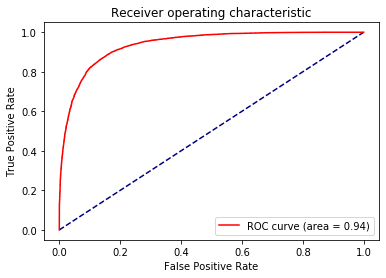

In [0]:
# Result
printResult(y_pred_tfidf_with_stop_nb, y_prob_tfidf_with_stop_nb)

> TFIDF without Stop Words Features

In [0]:
model = MultinomialNB()
# Training
model.fit(tfidf_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_no_stop_nb = model.predict(tfidf_no_stop_test_features)

prob_model = model.predict_proba(tfidf_no_stop_test_features)
y_prob_tfidf_no_stop_nb = []
for i in range(len(y_pred_tfidf_no_stop_nb)):
    y_prob_tfidf_no_stop_nb.append(prob_model[i][y_pred_tfidf_no_stop_nb[i]])

Accuracy: 84.59

Confusion Matrix:
 [[10776  1724]
 [ 2128 10372]]
              precision    recall  f1-score   support

          -1       0.84      0.86      0.85     12500
           1       0.86      0.83      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Area under the ROC curve : 0.925513


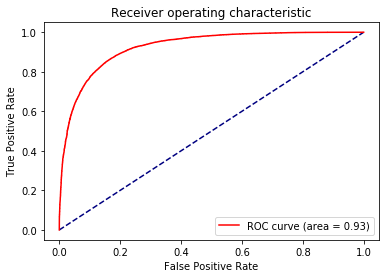

In [0]:
# Result
printResult(y_pred_tfidf_no_stop_nb, y_prob_tfidf_no_stop_nb)

> Word2Vec with Stop Words Features

In [0]:
model = GaussianNB()
# Training 
model.fit(word2vec_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_with_stop_nb = model.predict(word2vec_with_stop_test_features)

prob_model = model.predict_proba(word2vec_with_stop_test_features)
y_prob_w2v_with_stop_nb = []
for i in range(len(y_pred_w2v_with_stop_nb)):
    y_prob_w2v_with_stop_nb.append(prob_model[i][y_pred_w2v_with_stop_nb[i]])

Accuracy: 66.46

Confusion Matrix:
 [[9009 3491]
 [4893 7607]]
              precision    recall  f1-score   support

          -1       0.65      0.72      0.68     12500
           1       0.69      0.61      0.64     12500

    accuracy                           0.66     25000
   macro avg       0.67      0.66      0.66     25000
weighted avg       0.67      0.66      0.66     25000

Area under the ROC curve : 0.729803


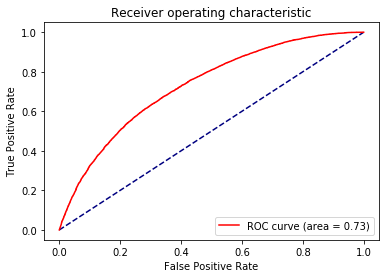

In [0]:
# Result
printResult(y_pred_w2v_with_stop_nb, y_prob_w2v_with_stop_nb)

> Word2Vec without Stop Words Features

In [0]:
model = GaussianNB()
# Training 
model.fit(word2vec_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_no_stop_nb = model.predict(word2vec_no_stop_test_features)

prob_model = model.predict_proba(word2vec_no_stop_test_features)
y_prob_w2v_no_stop_nb = []
for i in range(len(y_pred_w2v_no_stop_nb)):
    y_prob_w2v_no_stop_nb.append(prob_model[i][y_pred_w2v_no_stop_nb[i]])

Accuracy: 74.64

Confusion Matrix:
 [[9507 2993]
 [3347 9153]]
              precision    recall  f1-score   support

          -1       0.74      0.76      0.75     12500
           1       0.75      0.73      0.74     12500

    accuracy                           0.75     25000
   macro avg       0.75      0.75      0.75     25000
weighted avg       0.75      0.75      0.75     25000

Area under the ROC curve : 0.824367


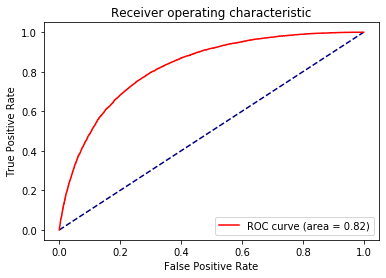

In [0]:
# Result
printResult(y_pred_w2v_no_stop_nb, y_prob_w2v_no_stop_nb)

> BERT Word Version Features

In [0]:
model = GaussianNB()

# Training 
model.fit(bert_word_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_words_nb = model.predict(bert_word_test_features)

prob_model = model.predict_proba(bert_word_test_features)
y_prob_bert_words_nb = []
for i in range(len(y_pred_bert_words_nb)):
    y_prob_bert_words_nb.append(prob_model[i][y_pred_bert_words_nb[i]])

Accuracy: 75.91

Confusion Matrix:
 [[10025  2475]
 [ 3547  8953]]
              precision    recall  f1-score   support

          -1       0.74      0.80      0.77     12500
           1       0.78      0.72      0.75     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000

Area under the ROC curve : 0.838560


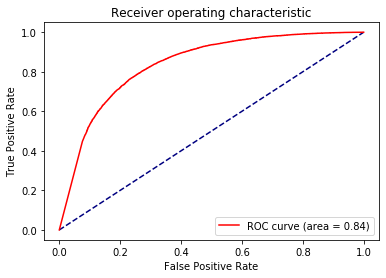

In [26]:
# Result
printResult(y_pred_bert_words_nb, y_prob_bert_words_nb)

> BERT Sentence Version Features

In [0]:
model = GaussianNB()

# Training 
model.fit(bert_sentence_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_sentences_nb = model.predict(bert_sentence_test_features)

prob_model = model.predict_proba(bert_sentence_test_features)
y_prob_bert_sentences_nb = []
for i in range(len(y_pred_bert_sentences_nb)):
    y_prob_bert_sentences_nb.append(prob_model[i][y_pred_bert_sentences_nb[i]])

Accuracy: 84.12

Confusion Matrix:
 [[10803  1697]
 [ 2274 10226]]
              precision    recall  f1-score   support

          -1       0.83      0.86      0.84     12500
           1       0.86      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Area under the ROC curve : 0.903041


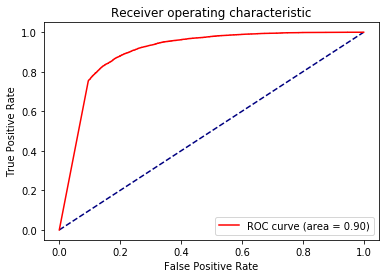

In [28]:
# Result
printResult(y_pred_bert_sentences_nb, y_prob_bert_sentences_nb)

# Decision tree

In [0]:
model = DecisionTreeClassifier()

> BOW Features

In [0]:
# Training
model.fit(bow_training_features, train_data["sentiment"])

# Evaluation
y_pred_bow_dt = model.predict(bow_test_features)

prob_model = model.predict_proba(bow_test_features)
y_prob_bow_dt = []
for i in range(len(y_pred_bow_dt)):
    y_prob_bow_dt.append(prob_model[i][y_pred_bow_dt[i]])

Accuracy: 72.26

Confusion Matrix:
 [[9112 3388]
 [3547 8953]]
              precision    recall  f1-score   support

          -1       0.72      0.73      0.72     12500
           1       0.73      0.72      0.72     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000

Area under the ROC curve : 0.722600


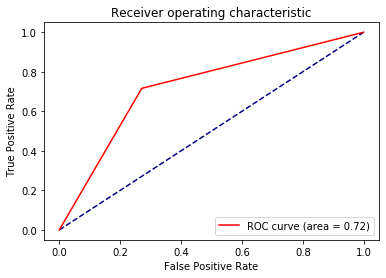

In [0]:
# Result
printResult(y_pred_bow_dt, y_prob_bow_dt)

> TFIDF with Stop Words Features

In [0]:
# Training
model.fit(tfidf_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_with_stop_dt = model.predict(tfidf_with_stop_test_features)

prob_model = model.predict_proba(tfidf_with_stop_test_features)
y_prob_tfidf_with_stop_dt = []
for i in range(len(y_pred_tfidf_with_stop_dt)):
    y_prob_tfidf_with_stop_dt.append(prob_model[i][y_pred_tfidf_with_stop_dt[i]])

Accuracy: 70.20

Confusion Matrix:
 [[8783 3717]
 [3733 8767]]
              precision    recall  f1-score   support

          -1       0.70      0.70      0.70     12500
           1       0.70      0.70      0.70     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000

Area under the ROC curve : 0.702000


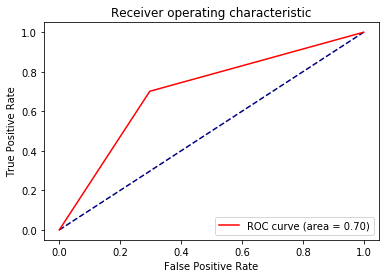

In [0]:
# Result
printResult(y_pred_tfidf_with_stop_dt, y_prob_tfidf_with_stop_dt)

> TFIDF without Stop Words Features

In [0]:
# Training
model.fit(tfidf_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_no_stop_dt = model.predict(tfidf_no_stop_test_features)

prob_model = model.predict_proba(tfidf_no_stop_test_features)
y_prob_tfidf_no_stop_dt = []
for i in range(len(y_pred_tfidf_no_stop_dt)):
    y_prob_tfidf_no_stop_dt.append(prob_model[i][y_pred_tfidf_no_stop_dt[i]])

Accuracy: 71.94

Confusion Matrix:
 [[9068 3432]
 [3584 8916]]
              precision    recall  f1-score   support

          -1       0.72      0.73      0.72     12500
           1       0.72      0.71      0.72     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000

Area under the ROC curve : 0.719360


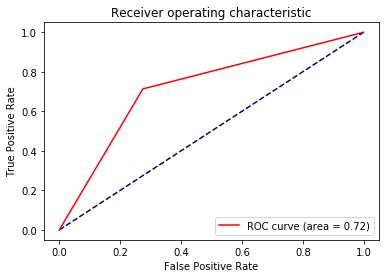

In [0]:
# Result
printResult(y_pred_tfidf_no_stop_dt, y_prob_tfidf_no_stop_dt)

> Word2Vec with Stop Words Features

In [0]:
# Training
model.fit(word2vec_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_with_stop_dt = model.predict(word2vec_with_stop_test_features)

prob_model = model.predict_proba(word2vec_with_stop_test_features)
y_prob_w2v_with_stop_dt = []
for i in range(len(y_pred_w2v_with_stop_dt)):
    y_prob_w2v_with_stop_dt.append(prob_model[i][y_pred_w2v_with_stop_dt[i]])

Accuracy: 66.76

Confusion Matrix:
 [[8367 4133]
 [4178 8322]]
              precision    recall  f1-score   support

          -1       0.67      0.67      0.67     12500
           1       0.67      0.67      0.67     12500

    accuracy                           0.67     25000
   macro avg       0.67      0.67      0.67     25000
weighted avg       0.67      0.67      0.67     25000

Area under the ROC curve : 0.667560


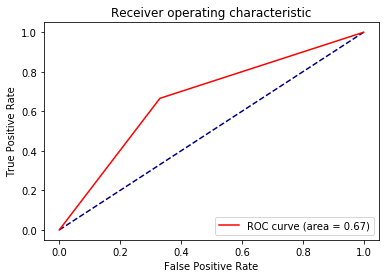

In [0]:
# Result
printResult(y_pred_w2v_with_stop_dt, y_prob_w2v_with_stop_dt)

> Word2Vec without Stop Words Features

In [0]:
# Training
model.fit(word2vec_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_no_stop_dt = model.predict(word2vec_no_stop_test_features)

prob_model = model.predict_proba(word2vec_no_stop_test_features)
y_prob_w2v_no_stop_dt = []
for i in range(len(y_pred_w2v_no_stop_dt)):
    y_prob_w2v_no_stop_dt.append(prob_model[i][y_pred_w2v_no_stop_dt[i]])

Accuracy: 72.28

Confusion Matrix:
 [[9221 3279]
 [3651 8849]]
              precision    recall  f1-score   support

          -1       0.72      0.74      0.73     12500
           1       0.73      0.71      0.72     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000

Area under the ROC curve : 0.722800


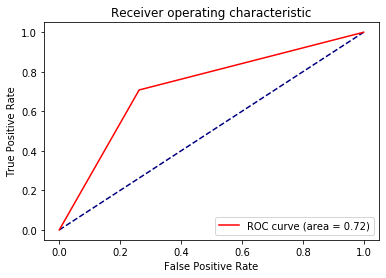

In [0]:
# Result
printResult(y_pred_w2v_no_stop_dt, y_prob_w2v_no_stop_dt)

> BERT Word Version Features

In [0]:
# Training
model.fit(bert_word_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_words_dt = model.predict(bert_word_test_features)

prob_model = model.predict_proba(bert_word_test_features)
y_prob_bert_words_dt = []
for i in range(len(y_pred_bert_words_dt)):
    y_prob_bert_words_dt.append(prob_model[i][y_pred_bert_words_dt[i]])

Accuracy: 75.91

Confusion Matrix:
 [[10025  2475]
 [ 3547  8953]]
              precision    recall  f1-score   support

          -1       0.74      0.80      0.77     12500
           1       0.78      0.72      0.75     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000

Area under the ROC curve : 0.838560


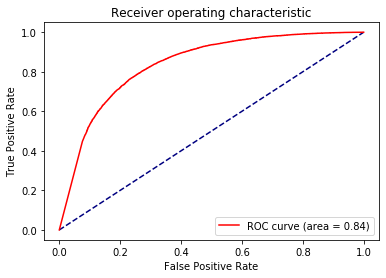

In [30]:
# Result
printResult(y_pred_bert_words_dt, y_prob_bert_words_dt)

> BERT Sentence Version Features

In [0]:
# Training
model.fit(bert_sentence_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_sentences_dt = model.predict(bert_sentence_test_features)

prob_model = model.predict_proba(bert_sentence_test_features)
y_prob_bert_sentences_dt = []
for i in range(len(y_pred_bert_sentences_dt)):
    y_prob_bert_sentences_dt.append(prob_model[i][y_pred_bert_sentences_dt[i]])

Accuracy: 84.12

Confusion Matrix:
 [[10803  1697]
 [ 2274 10226]]
              precision    recall  f1-score   support

          -1       0.83      0.86      0.84     12500
           1       0.86      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Area under the ROC curve : 0.903041


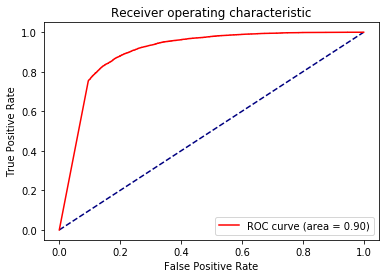

In [32]:
# Result
printResult(y_pred_bert_sentences_dt, y_prob_bert_sentences_dt)

# Random Forest

In [0]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

> BOW Features

In [0]:
# Training
model.fit(bow_training_features, train_data["sentiment"])

# Evaluation
y_pred_bow_rf = model.predict(bow_test_features)

prob_model = model.predict_proba(bow_test_features)
y_prob_bow_rf = []
for i in range(len(y_pred_bow_rf)):
    y_prob_bow_rf.append(prob_model[i][y_pred_bow_rf[i]])

Accuracy: 84.71

Confusion Matrix:
 [[10701  1799]
 [ 2024 10476]]
              precision    recall  f1-score   support

          -1       0.84      0.86      0.85     12500
           1       0.85      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Area under the ROC curve : 0.923153


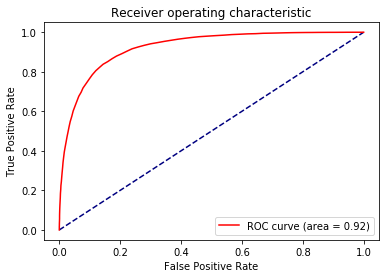

In [0]:
# Result
printResult(y_pred_bow_rf, y_prob_bow_rf)

> TFIDF with Stop Words Features

In [0]:
# Training
model.fit(tfidf_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_with_stop_rf = model.predict(tfidf_with_stop_test_features)

prob_model = model.predict_proba(tfidf_with_stop_test_features)
y_prob_tfidf_with_stop_rf = []
for i in range(len(y_pred_tfidf_with_stop_rf)):
    y_prob_tfidf_with_stop_rf.append(prob_model[i][y_pred_tfidf_with_stop_rf[i]])

Accuracy: 84.72

Confusion Matrix:
 [[10720  1780]
 [ 2040 10460]]
              precision    recall  f1-score   support

          -1       0.84      0.86      0.85     12500
           1       0.85      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Area under the ROC curve : 0.924936


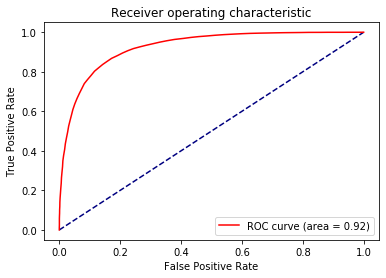

In [0]:
# Result
printResult(y_pred_tfidf_with_stop_rf, y_prob_tfidf_with_stop_rf)

> TFIDF without Stop Words Features

In [0]:
# Training
model.fit(tfidf_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_tfidf_no_stop_rf = model.predict(tfidf_no_stop_test_features)

prob_model = model.predict_proba(tfidf_no_stop_test_features)
y_prob_tfidf_no_stop_rf = []
for i in range(len(y_pred_tfidf_no_stop_rf)):
    y_prob_tfidf_no_stop_rf.append(prob_model[i][y_pred_tfidf_no_stop_rf[i]])

Accuracy: 85.31

Confusion Matrix:
 [[10777  1723]
 [ 1949 10551]]
              precision    recall  f1-score   support

          -1       0.85      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Area under the ROC curve : 0.928383


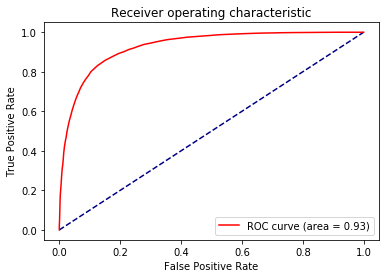

In [0]:
# Result
printResult(y_pred_tfidf_no_stop_rf, y_prob_tfidf_no_stop_rf)

> Word2Vec with Stop Words Features

In [0]:
# Training
model.fit(word2vec_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_with_stop_rf = model.predict(word2vec_with_stop_test_features)

prob_model = model.predict_proba(word2vec_with_stop_test_features)
y_prob_w2v_with_stop_rf = []
for i in range(len(y_pred_w2v_with_stop_rf)):
    y_prob_w2v_with_stop_rf.append(prob_model[i][y_pred_w2v_with_stop_rf[i]])

Accuracy: 79.22

Confusion Matrix:
 [[9956 2544]
 [2652 9848]]
              precision    recall  f1-score   support

          -1       0.79      0.80      0.79     12500
           1       0.79      0.79      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000

Area under the ROC curve : 0.872984


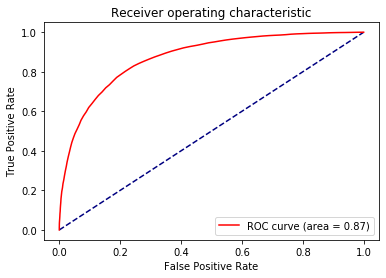

In [0]:
# Result
printResult(y_pred_w2v_with_stop_rf, y_prob_w2v_with_stop_rf)

> Word2Vec without Stop Words Features

In [0]:
# Training
model.fit(word2vec_no_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_no_stop_rf = model.predict(word2vec_no_stop_test_features)

prob_model = model.predict_proba(word2vec_no_stop_test_features)
y_prob_w2v_no_stop_rf = []
for i in range(len(y_pred_w2v_no_stop_rf)):
    y_prob_w2v_no_stop_rf.append(prob_model[i][y_pred_w2v_no_stop_rf[i]])

Accuracy: 82.11

Confusion Matrix:
 [[10288  2212]
 [ 2260 10240]]
              precision    recall  f1-score   support

          -1       0.82      0.82      0.82     12500
           1       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Area under the ROC curve : 0.899473


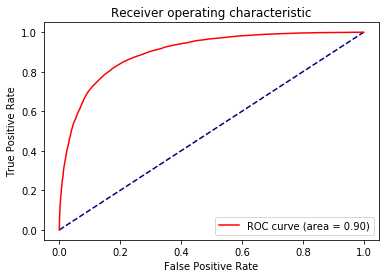

In [0]:
# Result
printResult(y_pred_w2v_no_stop_rf, y_prob_w2v_no_stop_rf)

> BERT Word Version Features

In [0]:
# Training
model.fit(bert_word_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_words_rf = model.predict(bert_word_test_features)

prob_model = model.predict_proba(bert_word_test_features)
y_prob_bert_words_rf = []
for i in range(len(y_pred_bert_words_rf)):
    y_prob_bert_words_rf.append(prob_model[i][y_pred_bert_words_rf[i]])

Accuracy: 81.97

Confusion Matrix:
 [[10316  2184]
 [ 2324 10176]]
              precision    recall  f1-score   support

          -1       0.82      0.83      0.82     12500
           1       0.82      0.81      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Area under the ROC curve : 0.901872


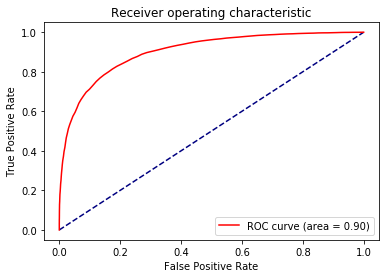

In [37]:
# Result
printResult(y_pred_bert_words_rf, y_prob_bert_words_rf)

> BERT Sentence Version Features

In [0]:
# Training
model.fit(bert_sentence_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_sentences_rf = model.predict(bert_sentence_test_features)

prob_model = model.predict_proba(bert_sentence_test_features)
y_prob_bert_sentences_rf = []
for i in range(len(y_pred_bert_sentences_rf)):
    y_prob_bert_sentences_rf.append(prob_model[i][y_pred_bert_sentences_rf[i]])

Accuracy: 85.97

Confusion Matrix:
 [[10724  1776]
 [ 1731 10769]]
              precision    recall  f1-score   support

          -1       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Area under the ROC curve : 0.935962


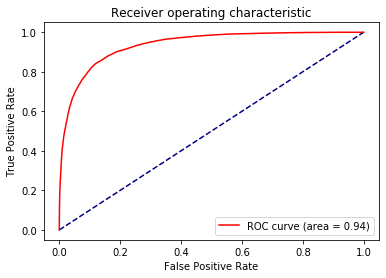

In [39]:
# Result
printResult(y_pred_bert_sentences_rf, y_prob_bert_sentences_rf)

# Conclusion